In [2]:
import os
import re
import json
import csv
import rdkit
import matplotlib.pyplot as plt

# This is relative to the root directory of this repository
outdir = "out/linkinvent"


# get the notebook's root path
try: ipynb_path
except NameError: ipynb_path = os.getcwd()

root = os.path.abspath(os.path.join(ipynb_path, '..'))
outpath = os.path.join(root, outdir)

os.makedirs(outpath, exist_ok=True)

In [3]:
def dump_input_and_return_path(inputs):
    dump_path = os.path.join(outpath, 'link_invent_input.csv')

    with open(dump_path, 'w', newline='') as f:
        csvwriter = csv.writer(f)
        for row in inputs:
            csvwriter.writerow([row])
    return dump_path

In [171]:
input_path = dump_input_and_return_path(["Oc1cncc(*)c1|*c1ccoc1"])
# input_path = dump_input_and_return_path(["Oc1cncc(*)c1|CSCCO*"])

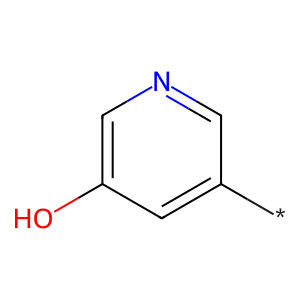

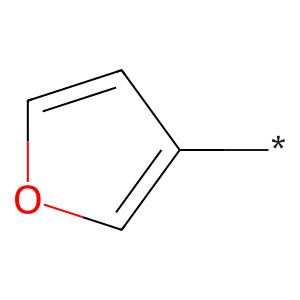

In [172]:

# Visualize input moelcules

with open(input_path) as fp:
    while True:
        mol = fp.readline()
        if mol == '':
            break
        for s in mol.split("|"):
            m = rdkit.Chem.MolFromSmiles(s)
            display(rdkit.Chem.Draw.MolToImage(m))


In [173]:
config = {
    "run_type": "sampling",
    "parameters": {
        "model_file": os.path.join(root, "priors/linkinvent.prior"),
        "unique_molecules": True,
        "randomize_smiles": True,
        "smiles_file": input_path
    }
}

def dump_config_and_return_path(num_smiles=500):
    config["use_cuda"] = False
    config["parameters"]["num_smiles"] = num_smiles
    config["parameters"]["output_file"] = os.path.join(outpath, f"linkinvent_{num_smiles}.csv")
    
    dump_path = os.path.join(outpath, f"libinvent_generate_config.json")
    
    
    with open(dump_path, 'w') as f:
        json.dump(config, f, indent=4)
        
    return dump_path

In [174]:
config_path = dump_config_and_return_path()

In [175]:
!reinvent {config_path} -f json

18:29:14 <INFO> Started REINVENT 4.1.8 (C) AstraZeneca 2017, 2023 on 2024-05-06
18:29:14 <INFO> Command line: C:\Users\ankit\mambaforge\envs\eos57bx\Scripts\reinvent D:\projects\github\REINVENT4_NOTEBOOKS\out/linkinvent\libinvent_generate_config.json -f json
18:29:14 <INFO> User ankit on host Ank
18:29:14 <INFO> Python version 3.10.13
18:29:14 <INFO> PyTorch version 1.12.1+cu113, git 664058fa83f1d8eede5d66418abff6e20bd76ca8
18:29:14 <INFO> PyTorch compiled with CUDA version 11.3
18:29:14 <INFO> RDKit version 2023.09.5
18:29:14 <INFO> Platform Windows-10-10.0.26200-SP0
18:29:14 <INFO> Number of PyTorch CUDA devices 1
18:29:14 <INFO> Using CPU AMD64 Family 25 Model 80 Stepping 0, AuthenticAMD
18:29:14 <INFO> Starting Sampling
18:29:14 <INFO> D:\projects\github\REINVENT4_NOTEBOOKS\priors/linkinvent.prior has valid hash:
{ 'comments': [],
  'creation_date': 0,
  'date_format': 'UNIX epoch',
  'hash_id': '5792256bf6777dd630ed9ec66fbb4bbc',
  'hash_id_format': 'xxhash.xxh3_128_hex 3.4.1',
  

In [176]:
# Visualize utils
def molecule_from_smiles_img(smi):
    return rdkit.Chem.Draw.MolToImage(rdkit.Chem.MolFromSmiles(smi))

def clean_filename(filename, replace="-"):
    whitelist = "-_.() %s%s" % (string.ascii_letters, string.digits)
    char_limit = 255
    # replace spaces
    for r in replace:
        filename = filename.replace(r, "_")

    # keep only valid ascii chars
    cleaned_filename = (
        unicodedata.normalize("NFKD", filename).encode("ASCII", "ignore").decode()
    )

    # keep only whitelisted chars
    cleaned_filename = "".join(c for c in cleaned_filename if c in whitelist)

    return cleaned_filename[:char_limit]

def plot_molecules(given, warheads, linker):
    warheads = warheads.split("|")

    total_axes = len(warheads) + 2
    
    fig, axs = plt.subplots(
        1, total_axes, figsize=(10, 5)
    )  # Create a subplot with 1 row and 2 columns


    for i in range(total_axes):
        axs[i].axis("off")
    
    
    # Draw the input molecule
    axs[0].imshow(molecule_from_smiles_img(given))
    axs[0].set_title("Result")

    axs[total_axes - 1].set_title("Result - Linker")
    axs[total_axes - 1].imshow(molecule_from_smiles_img(linker))

    for i in range(total_axes - 2):
        offset = i + 1
        axs[offset].set_title(f"Input - Warhead {i}")
        axs[offset].imshow(molecule_from_smiles_img(warheads[i]))

    
    try:
        filename = linker + "_".join(warheads)
        filename = clean_filename(filename)
        filename += ".jpg"
        
        plt.savefig(
            os.path.join(outpath, 'images', filename),
            dpi=500,
            bbox_inches="tight",
        )
    except Exception as e:
        print(e)
        pass

    plt.show()


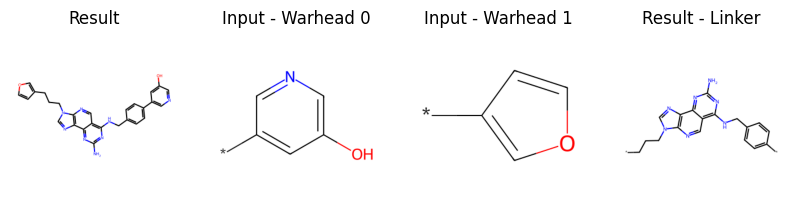

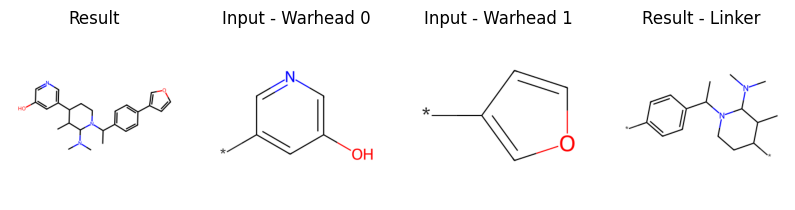

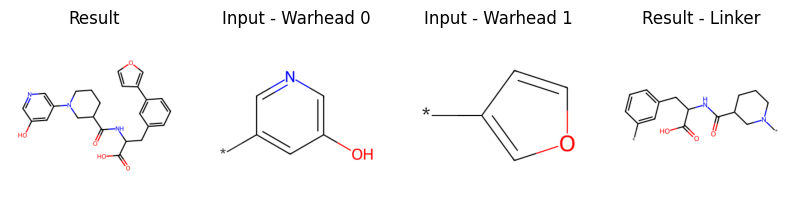

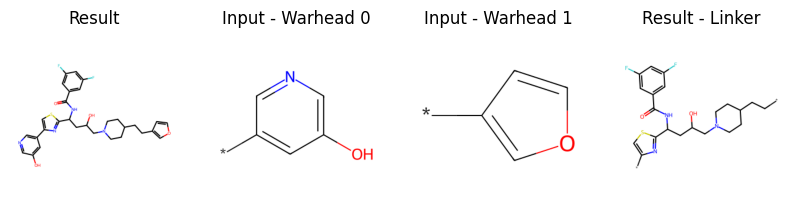

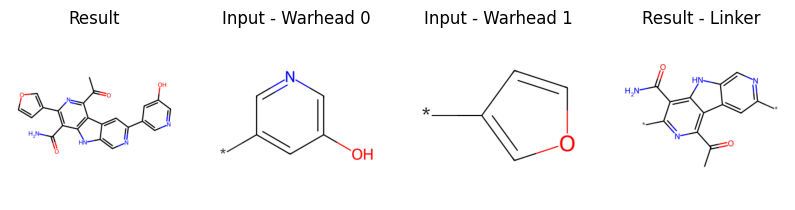

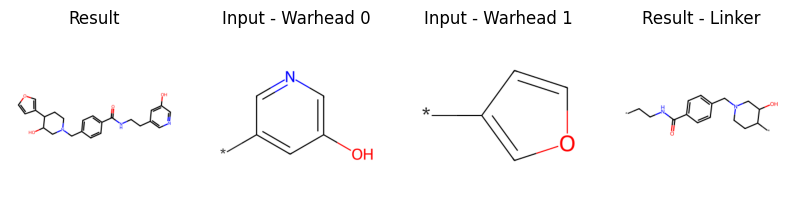

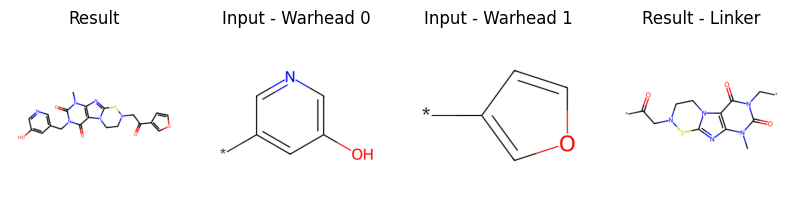

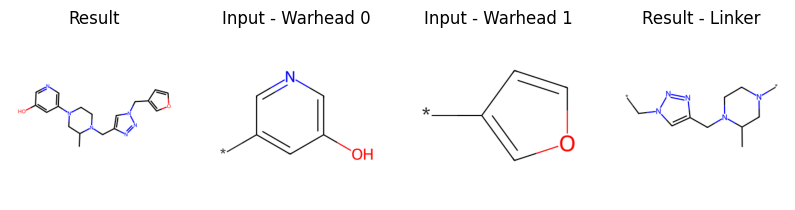

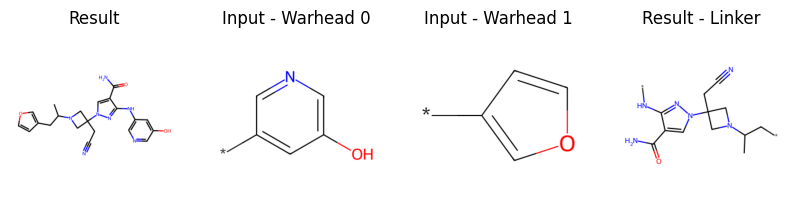

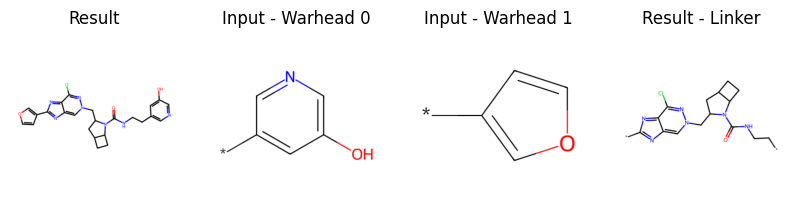

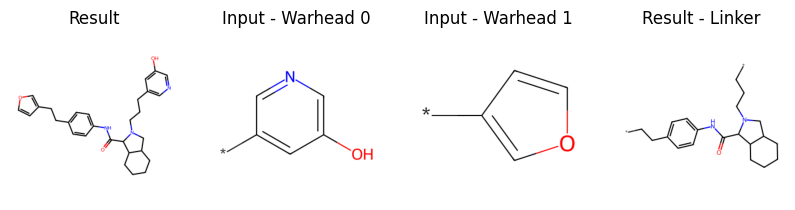

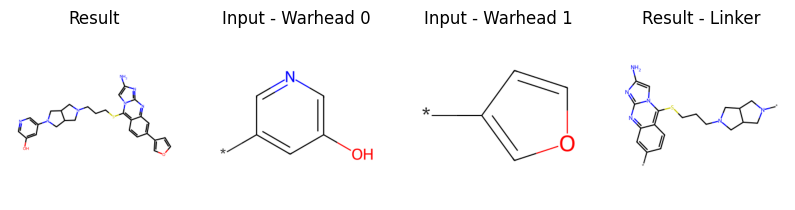

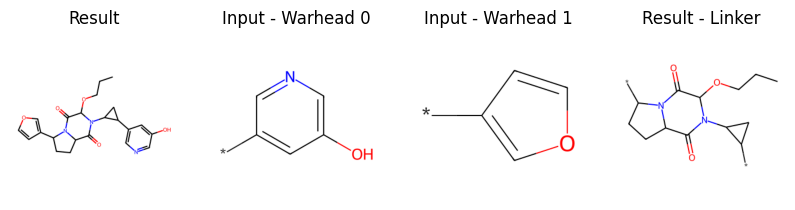

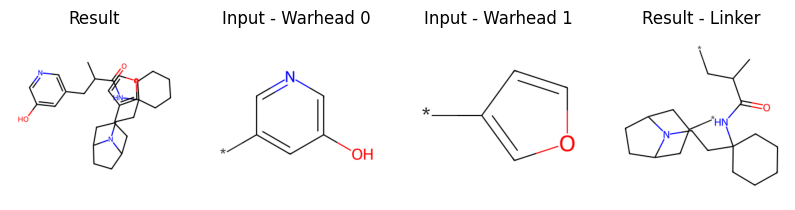

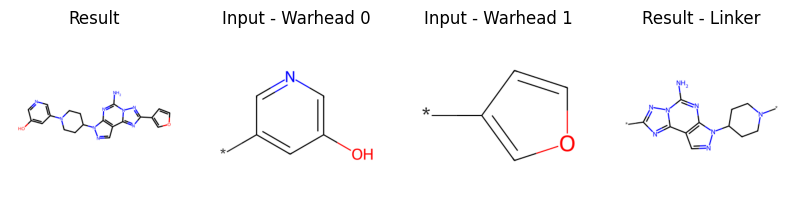

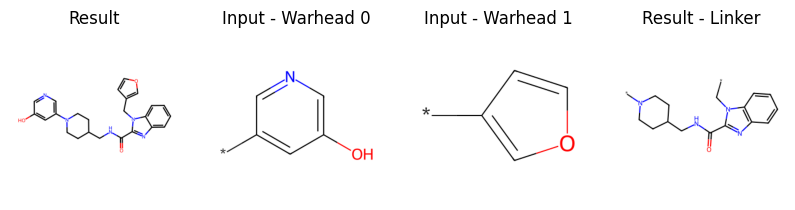

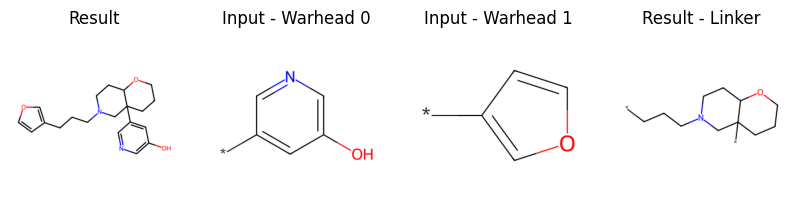

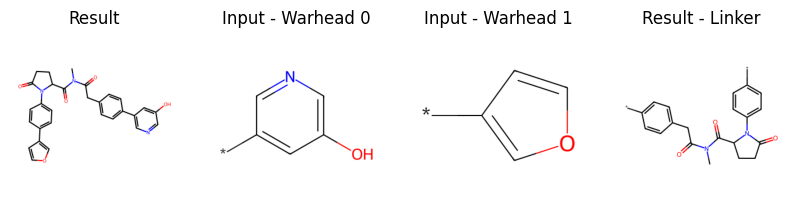

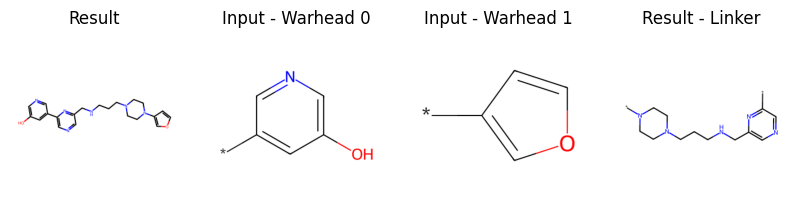

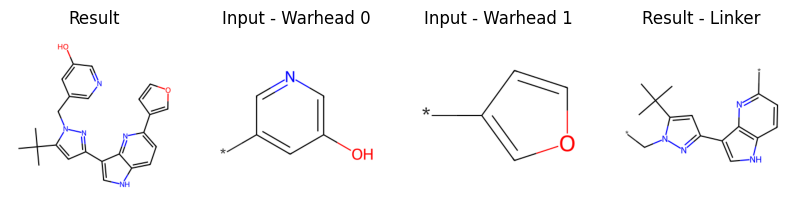

In [177]:
# Visualize molecules

output_csv_path = ""
with open(config_path) as fp:
    config = json.load(fp)
    output_csv_path = config['parameters']['output_file']


count = 0

def clean_smiles(smiles):
    return ''.join([c for c in smiles if c.isdigit() or c.isalpha() or c in ['(', ')', '[', ']', '=', '.', '@', '+', '-', '%', ' '] ])

with open(output_csv_path) as fp:
    csvreader = csv.reader(fp)
    next(csvreader)
    for row in csvreader:
        count += 1
        if count > 20:
            break
        plot_molecules(row[0], row[1], row[2])